# Deep Learning & Art: Neural Style Transfer

In this notebook, adapted from Deeplearning.ai's Deep Learning course, we will learn about Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**Objectives:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 
- Define the style cost function for Neural Style Transfer
- Define the content cost function for Neural Style Transfer

Most of the algorithms we've studied optimize a cost function to get a set of parameter values. With Neural Style Transfer, we'll get to optimize a cost function to get pixel values.

In [ ]:
# uncomment the following line to install the packages.
# !pip install numpy  matplotlib scipy Pillow pandas tensorflow

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

Neural Style Transfer (NST) is a fascinating optimization technique in deep learning that combines two images: a **"content" image (C)** and a **"style" image (S)**, to create a **"generated" image (G)**. The generated image G integrates the "content" of image C with the "style" of image S.

In this notebook, the objective is to blend the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (style image S) to produce the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">


## Transfer Learning

Neural Style Transfer (NST) leverages a pre-trained convolutional network and builds upon it. This approach, known as transfer learning, involves using a network trained for one task and applying it to a different but related task.

The VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) by the Visual Geometry Group at the University of Oxford in 2014 will be used. Specifically, VGG-19, a 19-layer variant of the VGG network, will be employed. This model has been trained on the extensive ImageNet database, learning to identify a wide range of features—from low-level features in the shallower layers to high-level features in the deeper layers.

Run the following code to load the parameters from the VGG model. This process may take a few seconds.


In [2]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

## Neural Style Transfer (NST)

The Neural Style Transfer (NST) algorithm will be developed in three steps:

- **First**, the content cost function $ J_{content}(C, G) $ will be constructed.
- **Second**, the style cost function $ J_{style}(S, G) $ will be formulated.
- **Finally**, both functions will be combined to obtain $ J(G) = \alpha J_{content}(C, G) + \beta J_{style}(S, G) $. Exciting!

### Computing the Content Cost


#### Aligning Generated Image G with the Content of Image C

A primary goal in Neural Style Transfer (NST) is to ensure that the content of the generated image G matches the content of the image C. This involves understanding the distinction between **shallow** and **deep** layers in a convolutional network:

* **Shallow layers** detect lower-level features such as *edges and simple textures*.
* **Deep layers** detect higher-level features such as *complex textures and object classes*.

#### Selecting a "Middle" Activation Layer $ a^{[l]} $:

To achieve a match between the content of the generated image G and the input image C, it is crucial to choose an appropriate activation layer:

* For visually pleasing results, selecting a layer from the middle of the network—neither too shallow nor too deep—is recommended. This approach ensures that the network captures both high-level and low-level features.
* Experimenting with different layers may yield varied results, so feel free to revisit and try different layers to observe their effects.

#### Forward Propagation for Image C:

* Set image C as the input to the pre-trained VGG network and perform forward propagation.
* Let $ a^{(C)} $ represent the activations from the chosen layer for image C. This tensor will have dimensions $ n_H \times n_W \times n_C $.

#### Forward Propagation for Image G:

* Repeat the forward propagation process with image G.
* Let $ a^{(G)} $ represent the activations from the corresponding layer for image G.

In this example, the content image C will be a picture of the Louvre Museum in Paris. Run the code below to view the picture of the Louvre.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


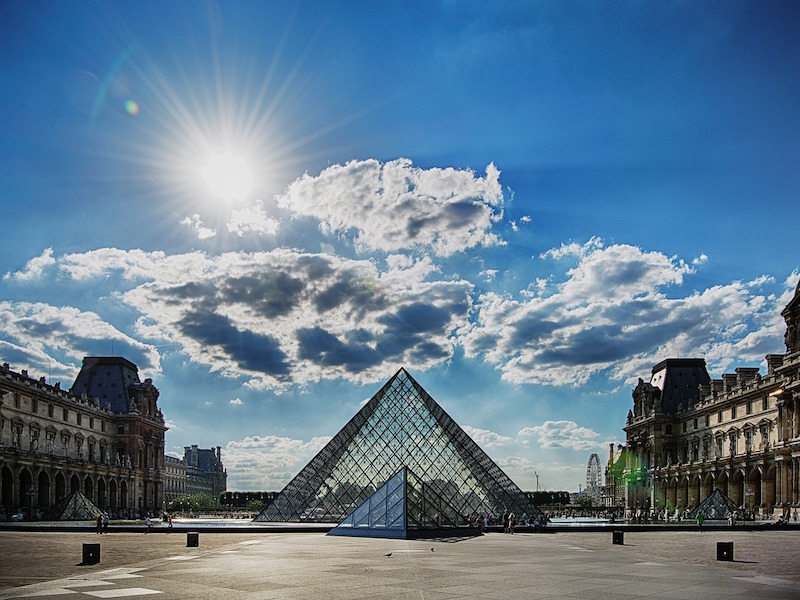

In [3]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

#### Content Cost Function $ J_{content}(C,G) $

A primary goal in Neural Style Transfer (NST) is to ensure that the content of the generated image $ G $ matches the content of the image $ C $. This is achieved by calculating the content cost function, defined as:

$$
J_{content}(C,G) = \frac{1}{4 \times n_H \times n_W \times n_C} \sum_{\text{all entries}} (a^{(C)} - a^{(G)})^2 \tag{1}
$$

- Here, $ n_H $, $ n_W $, and $ n_C $ denote the height, width, and number of channels of the chosen hidden layer, respectively. These parameters appear in the normalization term of the cost function.
- $ a^{(C)} $ and $ a^{(G)} $ are the 3D volumes corresponding to the activations from the hidden layer for images $ C $ and $ G $.
- To compute $ J_{content}(C,G) $, it may be useful to flatten these 3D volumes into a 2D matrix, as illustrated below.
- While this unrolling step isn't strictly necessary for computing $ J_{content} $, it will be beneficial for similar operations, such as calculating the style cost $ J_{style} $.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">


### compute_content_cost

The goal is to compute the "content cost" using TensorFlow.

**Descriptions**:

- `a_G`: Hidden layer activations representing the content of the image $ G $.
- `a_C`: Hidden layer activations representing the content of the image $ C $.

To implement this function, follow these three steps:

1. **Retrieve Dimensions from `a_G`:**
    - Use `X.get_shape().as_list()` to obtain the dimensions of a tensor `X`.

2. **Unroll `a_C` and `a_G`:**
    - Convert the 4D tensors `a_C` and `a_G` into 2D matrices.
    - Functions that may be useful include: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
    - Unrolling involves changing the shape from $(m, n_H, n_W, n_C)$ to $(m, n_H \times n_W, n_C)$.

3. **Compute the Content Cost:**
    - Useful functions for this step include: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square), and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).

#### Notes

- To unroll the tensor, reshape it from $(m, n_H, n_W, n_C)$ to $(m, n_H \times n_W, n_C)$.
- `tf.reshape(tensor, shape)` requires a list of integers for the desired output shape. Using `-1` in the shape list allows TensorFlow to infer the correct dimension size.
- For instance, `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` is equivalent to `tf.reshape(a_C, shape=[m, -1, n_C])`.
- To reorder dimensions, use `tf.transpose(tensor, perm)`, where `perm` specifies the new order of dimensions. For example, `tf.transpose(a_C, perm=[0, 3, 1, 2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.

*While `tf.transpose` is not strictly necessary for unrolling, it is a useful function for reordering dimensions in various scenarios.*


In [6]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G'
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C, shape=[1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, n_H * n_W, n_C])
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content

In [7]:
compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


**Key Points:**
    
- The content cost function evaluates the difference between the hidden layer activations $ a^{(C)} $ and $ a^{(G)} $.
- Minimizing this content cost will help ensure that the generated image $ G $ retains content similar to that of the original image $ C $.


<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

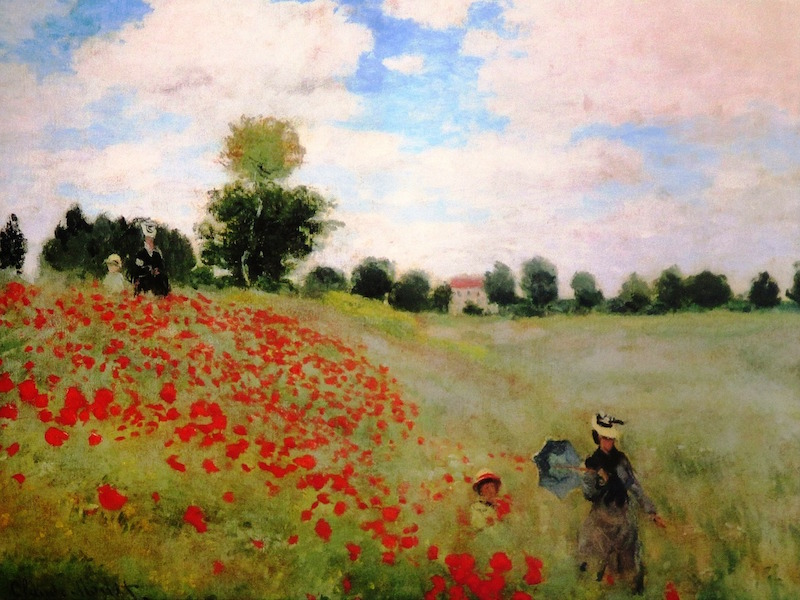

In [8]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's see how to define a "style" cost function $J_{style}(S,G)$!

#### Style Matrix

#### Gram Matrix
- The style matrix is also known as the **Gram matrix**.
- In linear algebra, the Gram matrix $ G $ for a set of vectors $ (v_{1}, \dots, v_{n}) $ is a matrix of dot products, where each entry is given by $ G_{ij} = v_{i}^T v_{j} = \text{np.dot}(v_{i}, v_{j}) $.
- Essentially, $ G_{ij} $ measures the similarity between vectors $ v_i $ and $ v_j $. If they are highly similar, their dot product will be large, resulting in a larger $ G_{ij} $.

#### Two Meanings of the Variable $ G $
- There is a variable name overlap here: 
  - $ G $ represents the Style matrix (or Gram matrix).
  - $ G $ also denotes the generated image.
- To avoid confusion, in this assignment:
  - $ G_{gram} $ will refer to the Gram matrix.
  - $ G $ will denote the generated image.



#### Compute Gram matrix $G_{gram}$
You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

### gram_matrix
* Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is $G_A = AA^T$.

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """ 
    # [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) and [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose).
    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [10]:
gram_matrix_test(gram_matrix)

GA = 
tf.Tensor(
[[ 63.193256  -26.729713   -7.732155 ]
 [-26.729713   12.775055   -2.5164719]
 [ -7.732155   -2.5164719  23.746586 ]], shape=(3, 3), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.193256  -26.729713   -7.732155 ] <br>
 [-26.729713   12.775055   -2.5164719] <br>
 [ -7.732155   -2.5164719  23.746586 ]] <br>
        </td>
    </tr>

</table>

#### Style Cost

The next objective is to minimize the distance between the Gram matrix of the **"style"** image $ S $ and the Gram matrix of the **"generated"** image $ G $.

- For now, focus on a single hidden layer $ a^{[l]} $.
- The style cost for this layer is defined as:

$$
J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G_{(gram)}^{(S)_{i,j}} - G_{(gram)}^{(G)_{i,j}})^2 \tag{2}
$$

- $ G_{(gram)}^{(S)} $ represents the Gram matrix of the **"style"** image.
- $ G_{(gram)}^{(G)} $ represents the Gram matrix of the **"generated"** image.
- This cost is computed using the hidden layer activations for a specific layer $ a^{[l]} $.


### compute_layer_style_cost

Compute the style cost for a single layer.

**Descriptions**: Follow these steps to implement this function:

1. Retrieve dimensions from the hidden layer activations $ a_G $:
    - To get the dimensions from a tensor $ X $, use: `X.get_shape().as_list()`
    
2. Unroll the hidden layer activations $ a_S $ and $ a_G $ into 2D matrices. This involves reshaping the activations, as illustrated in the sections "computing the content cost" and "style matrix":
    - Utilize [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) functions.
    
3. Compute the Style matrix for both images $ S $ and $ G $. (Use the function previously defined for this purpose.)
    
4. Compute the style cost:
    - Useful functions may include [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square), and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
#### Note
* Given that the activation dimensions are $ (m, n_H, n_W, n_C) $ and the desired unrolled matrix shape is $ (n_C, n_H \times n_W) $, reordering the filter dimension $ n_C $ might be necessary. Use `tf.transpose` to adjust the order of the filter dimension as needed.

In [11]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) 
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4.0 *(( n_H * n_W * n_C)**2))
        
    return J_style_layer

In [12]:
compute_layer_style_cost_test(compute_layer_style_cost)

J_style_layer = tf.Tensor(14.01649, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
           14.01649
        </td>
    </tr>

</table>

#### Style Weights

* So far, style has been captured from only one layer.
* To improve results, it's beneficial to combine style costs from multiple layers.
* Each layer will be assigned a weight ($\lambda^{[l]}$) to determine its influence on the overall style.
* After completing this exercise, experiment with different weights to see how they affect the generated image $G$.
* By default, assign equal weights to each layer, ensuring the weights sum to 1: 
  $$\sum_{l}^L \lambda^{[l]} = 1$$


Start by listing the layer names:

In [13]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Inspect the output of the layer `block5_conv4`. This layer will later be designated as the content layer, which will represent the image.

In [14]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now choose layers to represent the style of the image and assign style costs:

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

Combining the style costs for different layers gives:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


### compute_style_cost
Compute style cost

<b> Descriptions: </b>
* A compute_style_cost(...) function has already been implemented. 
* It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [16]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

Choosing coefficients for each layer involves balancing how different layers contribute to the style representation:

- Deeper layers capture higher-level concepts and have less localized features. To make the generated image softly follow the style image, assign larger weights to deeper layers and smaller weights to shallower layers.
- Conversely, if the goal is for the generated image to strongly adhere to the style image, assign smaller weights to deeper layers and larger weights to shallower layers.

<br>

**Key Points :**

- The style of an image is represented by the Gram matrix of activations from hidden layers.
- Combining representations from multiple layers improves results.
- Unlike content representation, which typically requires only one hidden layer, style representation benefits from multiple layers.
- Minimizing the style cost will make the generated image $G$ align with the style of image $S$.



### Defining the Total Cost to Optimize

Finally, we will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

### total_cost

The total cost function includes both the content cost and the style cost. 

In [17]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style

    return J

In [18]:
total_cost_test(total_cost)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>


**Key Points:**
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## Solving the Optimization Problem

Finally, it's time to integrate all the components and implement Neural Style Transfer!

The program will perform the following tasks:

1. Load the content image.
2. Load the style image.
3. Randomly initialize the generated image.
4. Load the VGG19 model.
5. Compute the content cost.
6. Compute the style cost.
7. Compute the total cost.
8. Define the optimizer and set the learning rate.

Below are the detailed steps for each part of the process.

### Load the Content Image
Run the following code cell to load, reshape, and normalize the "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


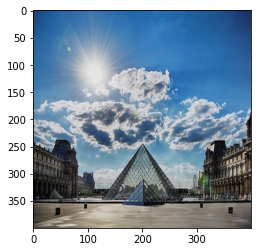

In [19]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### Load the Style Image
Now load, reshape and normalize the "style" image (Claude Monet's painting):

(1, 400, 400, 3)


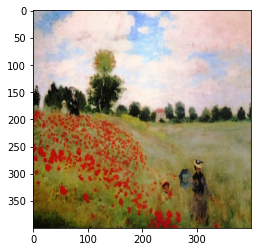

In [20]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

### Randomly Initialize the Generated Image

Initialize the "generated" image as a noisy version of the content image:

* This helps the generated image to be slightly correlated with the content image.
* Starting with an image that is mostly noise but slightly related to the content image ensures that the generated image more rapidly aligns with the content of the original image.


(1, 400, 400, 3)


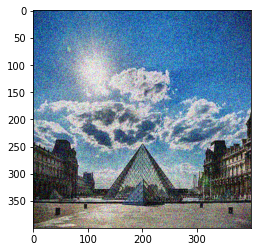

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

## Load Pre-trained VGG19 Model
The following function loads the VGG19 model and returns a list of the outputs for the middle layers.

In [22]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [23]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [24]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

### Compute Total Cost

#### Compute the Content Image Encoding (a_C)

Having built the model, the next step is to compute the content cost. This involves encoding the content image using the appropriate hidden layer activations. Set this encoding to the variable `a_C`. Later, you will need to do the same for the generated image by setting the variable `a_G` to the appropriate hidden layer activations. Use layer `block5_conv4` to compute the encoding. The code below performs the following:

- Sets `a_C` to the tensor representing the hidden layer activation for layer `block5_conv4` using the content image.


In [25]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

#### Compute the Style image Encoding (a_S) 

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [26]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utilities needed to display the images generated by the style transfer model.

In [27]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

### train_step 

**How it works:**
* Use the Adam optimizer to minimize the total cost `J`.
* Use a learning rate of 0.01
* Refer to the [Adam Optimizer documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
* Utilize [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the image.
* Within the tf.GradientTape():
   * Compute the encoding of the generated image using `vgg_model_outputs` and assign the result to `a_G`.
   * Compute the total cost `J`, using the global variables `a_C`, `a_S`, and the local `a_G`.
   * Use `alpha = 10` and `beta = 40`.


In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style,alpha = 10, beta = 40)
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [31]:
generated_image = tf.Variable(generated_image)

train_step_test(train_step, generated_image)

tf.Tensor(25700.346, shape=(), dtype=float32)
tf.Tensor(17778.389, shape=(), dtype=float32)
All tests passed


**Expected output**
```
tf.Tensor(25700.346, shape=(), dtype=float32)
tf.Tensor(17778.389, shape=(), dtype=float32)
```

### Train the Model

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

Epoch 0 


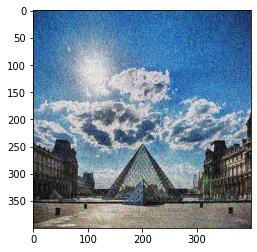

Epoch 250 


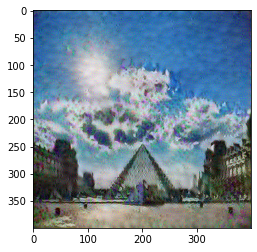

Epoch 500 


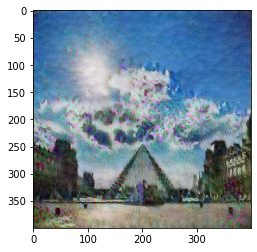

Epoch 750 


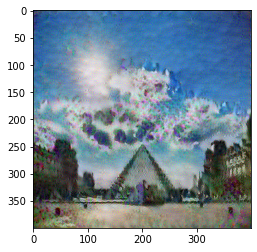

Epoch 1000 


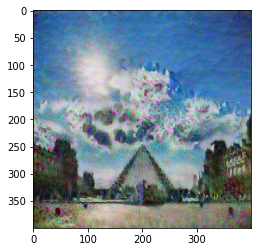

Epoch 1250 


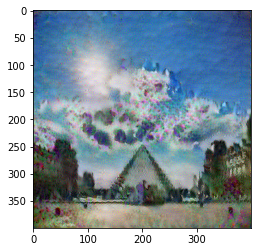

Epoch 1500 


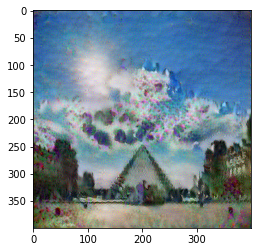

Epoch 1750 


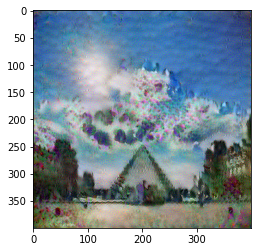

Epoch 2000 


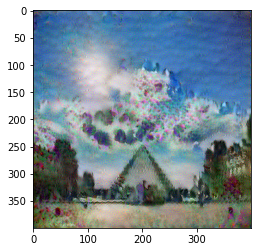

Epoch 2250 


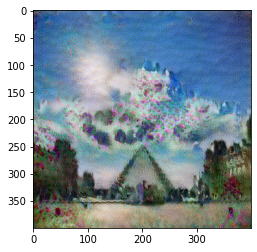

Epoch 2500 


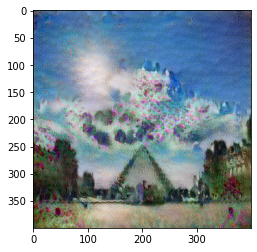

In [32]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

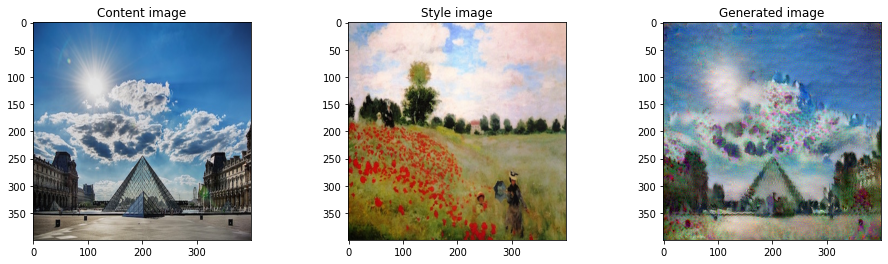

In [33]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

The `Generated image` on the right is the output from the model.

**Note:** 
- These results are from training the model with a `learning_rate=0.01` for `2501` epochs. To view intermediate results after every 250 epochs, navigate to `File --> Open...` and go to the `/output` directory to see all the saved images.
- The hyperparameters (`learning_rate=0.01` and `epochs=2501`) were chosen for a quick initial result. For improved outcomes, consider running the optimization algorithm longer with a smaller learning rate. Feel free to experiment further to generate better images. Running the optimization for around `epochs=20000` with a `learning_rate=0.001` should yield enhanced results, similar to the example image on the right.



<img src="images/louvre_generated.png" style="width:800px;height:300px;">


Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

## Test With Your Own Image

Finally, you can also rerun the algorithm on your own images! 

To do so, go back to part(4) and change the content image and style image with your own pictures. In detail, here's what you should do:

1. Click on "File -> Open" in the upper tab of the notebook
2. Go to "/images" and upload your images (images will scaled to 400x400, but you can change that parameter too in section 2), rename them "my_content.png" and "my_style.png" for example.
3. Change the code in [part(4)](#part(4)) from :

```py
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))

```

&emsp;&emsp;to:

``` py
content_image = np.array(Image.open("images/my_content.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("my_style.jpg").resize((img_size, img_size)))

```
4. Rerun the cells (you may need to restart the Kernel in the upper tab of the notebook).

You can share your generated images with us on social media with the hashtag #deeplearningAI or by tagging us directly!

Here are some ideas on how to tune your hyperparameters: 
- To select different layers to represent the style, redefine `STYLE_LAYERS`
- To alter the number of iterations you want to run the algorithm, try changing `epochs` given in Section 5.6.
- To alter the relative weight of content versus style, try altering alpha and beta values

Happy coding!

## Conclusion

Congratulations on completing this assignment! You've successfully applied Neural Style Transfer (NST) to create artistic images. This exercise also introduced a unique aspect of deep learning, where the optimization algorithm updates pixel values directly, rather than adjusting neural network parameters. This represents just one of the many fascinating approaches within deep learning.

### Key Points
- Neural Style Transfer is an algorithm that merges a content image $ C $ with a style image $ S $ to produce a visually artistic image.
- It leverages representations (hidden layer activations) from a pretrained convolutional network (ConvNet).
- The content cost function is calculated using activations from a single hidden layer.
- The style cost function for one layer is determined using the Gram matrix of that layer's activations, and the overall style cost is derived from multiple hidden layers.
- By optimizing the total cost function, new, stylistically enriched images are synthesized.

<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
